# Session 2 - Instrumental Variables

## Contents

- [Overview](#Overview)  
- [Simple Linear Regression](#Simple-Linear-Regression)  
- [Extending the Linear Regression Model](#Extending-the-Linear-Regression-Model)  
- [Endogeneity](#Endogeneity)  
- [Matrix Algebra](#Matrix-Algebra)
- [Next](#Next-Lecture)

In [1]:
# Import and setup matplotlib for graphs
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-white')

## Simple Linear Regression

[[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001) wish to determine whether or not differences in institutions can help to explain observed economic outcomes.

How do we measure *institutional differences* and *economic outcomes*?

In this paper,

- economic outcomes are proxied by log GDP per capita in 1995, adjusted for exchange rates.  
- institutional differences are proxied by an index of protection against expropriation on average over 1985-95, constructed by the [Political Risk Services Group](https://www.prsgroup.com/).  


These variables and other data used in the paper are available for download on Daron Acemoglu’s [webpage](https://economics.mit.edu/faculty/acemoglu/data/ajr2001).

We will use pandas’ `.read_stata()` function to read in data contained in the `.dta` files to dataframes

In [2]:
import pandas as pd

# Load Acemoglu Johnson Robinson Dataset
df = pd.read_csv('data/AJR02.csv')
df.head()

,shortnam,africa,lat_abst,rich4,avexpr,logpgp95,logem4,asia,loghjypl,baseco,catho80,muslim80,no_cpm80,f_brit,f_french,sjlofr,other
0,AFG,0,0.366667,0,NaN,NaN,4.540098,1,NaN,NaN,0.000000,99.300003,0.699997,1.0,0.0,1.0,0
1,AGO,1,0.136667,0,5.363637,7.770645,5.634790,0,-3.411248,1.0,68.699997,0.000000,11.500004,0.0,0.0,1.0,0
2,ARE,0,0.266667,0,7.181818,9.804219,NaN,1,NaN,NaN,0.400000,94.900002,4.399999,1.0,0.0,0.0,0
3,ARG,0,0.377778,0,6.386363,9.133459,4.232656,0,-0.872274,1.0,91.599998,0.200000,5.500001,0.0,0.0,1.0,0
4,ARM,0,0.444444,0,NaN,7.682482,NaN,1,NaN,NaN,0.000000,0.000000,100.000000,0.0,0.0,0.0,0


Let’s use a scatterplot to see whether any obvious relationship exists
between GDP per capita and the protection against
expropriation index

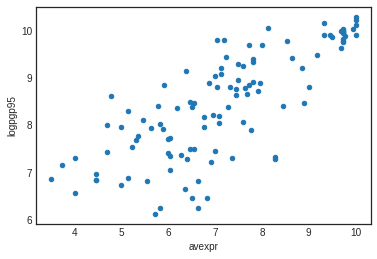

In [3]:
# Plot relationship between GDP and expropriation rate
df.plot(x='avexpr', y='logpgp95', kind='scatter');

The plot shows a fairly strong positive relationship between
protection against expropriation and log GDP per capita.

Specifically, if higher protection against expropriation is a measure of
institutional quality, then better institutions appear to be positively
correlated with better economic outcomes (higher GDP per capita).

Given the plot, choosing a linear model to describe this relationship
seems like a reasonable assumption.

We can write our model as

$$
{logpgp95}_i = \beta_0 + \beta_1 {avexpr}_i + \varepsilon_i
$$

where:

- $ \beta_0 $ is the intercept of the linear trend line on the
  y-axis  
- $ \beta_1 $ is the slope of the linear trend line, representing
  the *marginal effect* of protection against risk on log GDP per
  capita  
- $ u_i $ is a random error term (deviations of observations from
  the linear trend due to factors not included in the model)  


Visually, this linear model involves choosing a straight line that best
fits the data, as in the following plot (Figure 2 in [[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001))

In [4]:
# Dropping NA's is required to use numpy's polyfit
df_subset = df.dropna(subset=['logpgp95', 'avexpr'])

# Use only 'base sample' for plotting purposes
df_subset = df_subset[df_subset['baseco'] == 1]

X = df_subset['avexpr']
y = df_subset['logpgp95']
labels = df_subset['shortnam']

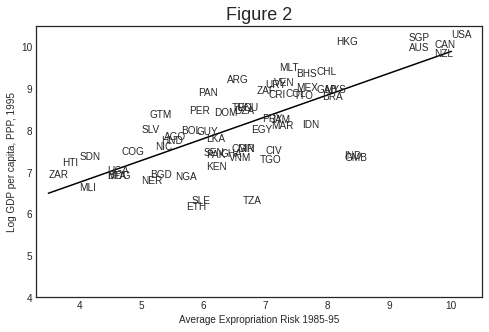

In [5]:
import numpy as np

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_title('Figure 2', fontsize=18);

ax.scatter(X, y, marker='')
# Replace markers with country labels
for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

ax.set_xlim([3.3,10.5])
ax.set_ylim([4,10.5])
ax.set_xlabel('Average Expropriation Risk 1985-95')
ax.set_ylabel('Log GDP per capita, PPP, 1995')
plt.show()

The most common technique to estimate the parameters ($ \beta $’s)
of the linear model is Ordinary Least Squares (OLS).

As the name implies, an OLS model is solved by finding the parameters
that minimize *the sum of squared residuals*, i.e.

$$
\underset{\hat{\beta}}{\min} \sum^N_{i=1}{\hat{u}^2_i}
$$

where $ \hat{u}_i $ is the difference between the observation and
the predicted value of the dependent variable.

To estimate the constant term $ \beta_0 $, we need to add a column
of 1’s to our dataset (consider the equation if $ \beta_0 $ was
replaced with $ \beta_0 x_i $ and $ x_i = 1 $)

In [6]:
df['const'] = 1

Now we can construct our model in `statsmodels` using the OLS function.

We will use `pandas` dataframes with `statsmodels`, however standard arrays can also be used as arguments

In [7]:
import statsmodels.api as sm

# Regress GDP on Expropriation Rate
reg1 = sm.OLS(endog=df['logpgp95'], exog=df[['const', 'avexpr']], \
    missing='drop')
type(reg1)

statsmodels.regression.linear_model.OLS

So far we have simply constructed our model.

We need to use `.fit()` to obtain parameter estimates
$ \hat{\beta}_0 $ and $ \hat{\beta}_1 $

In [8]:
# Fit regression
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

We now have the fitted regression model stored in `results`.

To view the OLS regression results, we can call the `.summary()`
method.

Note that an observation was mistakenly dropped from the results in the
original paper (see the note located in maketable2.do from Acemoglu’s webpage), and thus the
coefficients differ slightly.

In [9]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           4.16e-24
Time:                        08:38:36   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.301     15.391      0.000       4.030       5.222
avexpr         0.5319      0.041     13.093      0.000       0.451       0.612
==============================================================================
Omnibus:                        9.251   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.170
Skew:                          -0.680   Prob(JB):                       0.0102
Kurtosis:                       3.362   Cond. No.                         33.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From our results, we see that

- The intercept $ \hat{\beta}_0 = 4.63 $.  
- The slope $ \hat{\beta}_1 = 0.53 $.  
- The positive $ \hat{\beta}_1 $ parameter estimate implies that.
  institutional quality has a positive effect on economic outcomes, as
  we saw in the figure.  
- The p-value of 0.000 for $ \hat{\beta}_1 $ implies that the
  effect of institutions on GDP is statistically significant (using p <
  0.05 as a rejection rule).  
- The R-squared value of 0.611 indicates that around 61% of variation
  in log GDP per capita is explained by protection against
  expropriation.  


Using our parameter estimates, we can now write our estimated
relationship as

$$
\widehat{logpgp95}_i = 4.63 + 0.53 \ {avexpr}_i
$$

This equation describes the line that best fits our data, as shown in
Figure 2.

We can use this equation to predict the level of log GDP per capita for
a value of the index of expropriation protection.

For example, for a country with an index value of 7.07 (the average for
the dataset), we find that their predicted level of log GDP per capita
in 1995 is 8.38.

In [10]:
mean_expr = np.mean(df_subset['avexpr'])
mean_expr

6.5156250109375

In [11]:
predicted_logpdp95 = 4.63 + 0.53 * 7.07
predicted_logpdp95

8.3771

An easier (and more accurate) way to obtain this result is to use
`.predict()` and set $ constant = 1 $ and
$ {avexpr}_i = mean\_expr $

In [12]:
results.predict(exog=[1, mean_expr])

array([8.09156367])

We can obtain an array of predicted $ {logpgp95}_i $ for every value
of $ {avexpr}_i $ in our dataset by calling `.predict()` on our
results.

Plotting the predicted values against $ {avexpr}_i $ shows that the
predicted values lie along the linear line that we fitted above.

The observed values of $ {logpgp95}_i $ are also plotted for
comparison purposes

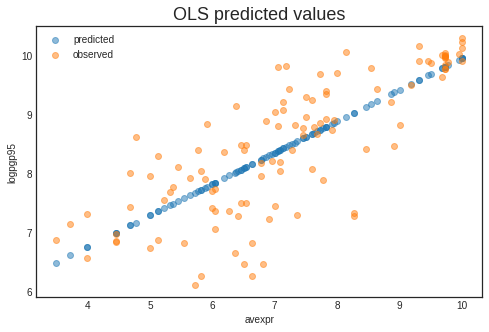

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_title('OLS predicted values', fontsize=18)

# Drop missing observations from whole sample
df_plot = df.dropna(subset=['logpgp95', 'avexpr'])
ax.scatter(df_plot['avexpr'], results.predict(), alpha=0.5,
        label='predicted')

# Plot observed values
ax.scatter(df_plot['avexpr'], df_plot['logpgp95'], alpha=0.5,
        label='observed')

ax.legend()
ax.set_xlabel('avexpr')
ax.set_ylabel('logpgp95')
plt.show()

## Extending the Linear Regression Model

So far we have only accounted for institutions affecting economic
performance - almost certainly there are numerous other factors
affecting GDP that are not included in our model.

Leaving out variables that affect $ logpgp95_i $ will result in **omitted variable bias**, yielding biased and inconsistent parameter estimates.

We can extend our bivariate regression model to a **multivariate regression model** by adding in other factors that may affect $ logpgp95_i $.

[[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001) consider other factors such as:

- the effect of climate on economic outcomes; latitude is used to proxy
  this  
- differences that affect both economic performance and institutions,
  eg. cultural, historical, etc.; controlled for with the use of
  continent dummies  


Let’s estimate some of the extended models considered in the paper
(Table 2) using data from `maketable2.dta`

In [14]:
# Add constant term to dataset
df['const'] = 1

# Create lists of variables to be used in each regression
X1 = ['const', 'avexpr']
X2 = ['const', 'avexpr', 'lat_abst']
X3 = ['const', 'avexpr', 'lat_abst', 'asia', 'africa', 'other']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df['logpgp95'], df[X1], missing='drop').fit()
reg2 = sm.OLS(df['logpgp95'], df[X2], missing='drop').fit()
reg3 = sm.OLS(df['logpgp95'], df[X3], missing='drop').fit()

Now that we have fitted our model, we will use `summary_col` to
display the results in a single table (model numbers correspond to those
in the paper)

In [15]:
from statsmodels.iolib.summary2 import summary_col


info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 3',
                                         'Model 4'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'avexpr',
                                             'lat_abst',
                                             'asia',
                                             'africa'])

results_table.add_title('Table 2 - OLS Regressions')
results_table

,Model 1,Model 3,Model 4
const,4.63***,4.87***,5.85***
,(0.30),(0.33),(0.34)
avexpr,0.53***,0.46***,0.39***
,(0.04),(0.06),(0.05)
lat_abst,,0.87*,0.33
,,(0.49),(0.45)
asia,,,-0.15
,,,(0.15)
africa,,,-0.92***
,,,(0.17)


## Endogeneity

As [[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001) discuss, the OLS models likely suffer from
**endogeneity** issues, resulting in biased and inconsistent model
estimates.

Namely, there is likely a two-way relationship between institutions and
economic outcomes:

- richer countries may be able to afford or prefer better institutions  
- variables that affect income may also be correlated with
  institutional differences  
- the construction of the index may be biased; analysts may be biased
  towards seeing countries with higher income having better
  institutions  


To deal with endogeneity, we can use **two-stage least squares (2SLS)
regression**, which is an extension of OLS regression.

This method requires replacing the endogenous variable
$ {avexpr}_i $ with a variable that is:

1. correlated with $ {avexpr}_i $  
1. not correlated with the error term (ie. it should not directly affect
  the dependent variable, otherwise it would be correlated with
  $ u_i $ due to omitted variable bias)  


The new set of regressors is called an **instrument**, which aims to
remove endogeneity in our proxy of institutional differences.

The main contribution of [[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001) is the use of settler mortality
rates to instrument for institutional differences.

They hypothesize that higher mortality rates of colonizers led to the
establishment of institutions that were more extractive in nature (less
protection against expropriation), and these institutions still persist
today.

Using a scatterplot (Figure 3 in [[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001)), we can see protection
against expropriation is negatively correlated with settler mortality
rates, coinciding with the authors’ hypothesis and satisfying the first
condition of a valid instrument.

In [16]:
# Dropping NA's is required to use numpy's polyfit
df_subset2 = df.dropna(subset=['logem4', 'avexpr'])
X = df_subset2['logem4']
y = df_subset2['avexpr']
labels = df_subset2['shortnam']

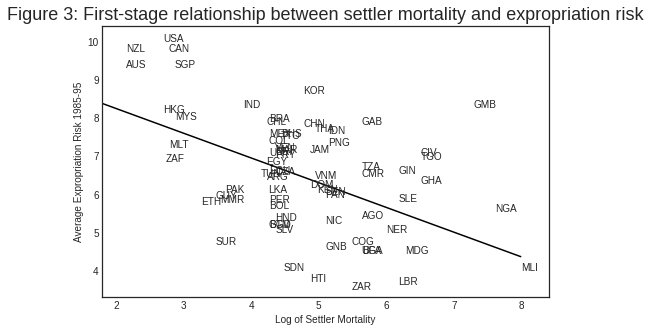

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_title('Figure 3: First-stage relationship between settler mortality and expropriation risk', fontsize=18)



# Replace markers with country labels
ax.scatter(X, y, marker='')
for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

ax.set_xlim([1.8,8.4])
ax.set_ylim([3.3,10.4])
ax.set_xlabel('Log of Settler Mortality')
ax.set_ylabel('Average Expropriation Risk 1985-95')
plt.show()

The second condition may not be satisfied if settler mortality rates in the 17th to 19th centuries have a direct effect on current GDP (in addition to their indirect effect through institutions).

For example, settler mortality rates may be related to the current disease environment in a country, which could affect current economic performance.

[[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001) argue this is unlikely because:

- The majority of settler deaths were due to malaria and yellow fever
  and had a limited effect on local people.  
- The disease burden on local people in Africa or India, for example,
  did not appear to be higher than average, supported by relatively
  high population densities in these areas before colonization.  


As we appear to have a valid instrument, we can use 2SLS regression to
obtain consistent and unbiased parameter estimates.

**First stage**

The first stage involves regressing the endogenous variable
($ {avexpr}_i $) on the instrument.

The instrument is the set of all exogenous variables in our model (and
not just the variable we have replaced).

Using model 1 as an example, our instrument is simply a constant and
settler mortality rates $ {logem4}_i $.

Therefore, we will estimate the first-stage regression as

$$
{avexpr}_i = \delta_0 + \delta_1 {logem4}_i + v_i
$$


In [26]:
# Import and select the data
df = df.loc[df['baseco']==1,:]

# Add a constant variable
df['const'] = 1

# Fit the first stage regression and print summary
results_fs = sm.OLS(df['avexpr'],
                    df[['const', 'logem4']],
                    missing='drop').fit()
results_fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 avexpr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     22.95
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           1.08e-05
Time:                        08:40:27   Log-Likelihood:                -104.83
No. Observations:                  64   AIC:                             213.7
Df Residuals:                      62   BIC:                             218.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3414      0.611     15.296      0.000       8.121      10.562
logem4        -0.6068      0.127     -4.790      0.000      -0.860      -0.354
==============================================================================
Omnibus:                        0.035   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.983   Jarque-Bera (JB):                0.172
Skew:                           0.045   Prob(JB):                        0.918
Kurtosis:                       2.763   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Second stage**

We need to retrieve the predicted values of $ {avexpr}_i $ using
`.predict()`.

We then replace the endogenous variable $ {avexpr}_i $ with the
predicted values $ \widehat{avexpr}_i $ in the original linear model.

Our second stage regression is thus

$$
{logpgp95}_i = \beta_0 + \beta_1 \widehat{avexpr}_i + u_i
$$

In [19]:
# Second stage
df['predicted_avexpr'] = results_fs.predict()

results_ss = sm.OLS(df.loc[:,'logpgp95'],
                    df.loc[:,['const', 'predicted_avexpr']]).fit()

# Print
results_ss.summary()

/home/mcourt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logpgp95   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     56.60
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           2.66e-10
Time:                        08:38:36   Log-Likelihood:                -72.268
No. Observations:                  64   AIC:                             148.5
Df Residuals:                      62   BIC:                             152.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9097      0.823      2.320      0.024       0.264       3.555
predicted_avexpr     0.9443      0.126      7.523      0.000       0.693       1.195
==============================================================================
Omnibus:                       10.547   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.010
Skew:                          -0.790   Prob(JB):                      0.00407
Kurtosis:                       4.277   Cond. No.                         58.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The second-stage regression results give us an unbiased and consistent
estimate of the effect of institutions on economic outcomes.

The result suggests a stronger positive relationship than what the OLS
results indicated.

Note that while our parameter estimates are correct, our standard errors
are not and for this reason, computing 2SLS ‘manually’ (in stages with
OLS) is not recommended.

We can correctly estimate a 2SLS regression in one step using the
[linearmodels](https://github.com/bashtage/linearmodels) package, an extension of `statsmodels`

Note that when using `IV2SLS`, the exogenous and instrument variables
are split up in the function arguments (whereas before the instrument
included exogenous variables)

In [20]:
from linearmodels.iv import IV2SLS

# IV regression
iv = IV2SLS(dependent=df['logpgp95'],
            exog=df['const'],
            endog=df['avexpr'],
            instruments=df['logem4']).fit(cov_type='unadjusted')

# Print
iv.summary

/home/mcourt/.local/lib/python3.6/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               logpgp95   R-squared:                      0.1870
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1739
No. Observations:                  64   F-statistic:                    37.568
Date:                Thu, Oct 08 2020   P-value (F-stat)                0.0000
Time:                        08:38:37   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.9097     1.0106     1.8897     0.0588     -0.0710      3.8903
avexpr         0.9443     0.1541     6.1293     0.0000      0.6423      1.2462
==============================================================================

Endogenous: avexpr
Instruments: logem4
Unadjusted Covariance (Homoskedastic)
Debiased: False
"""

Given that we now have consistent and unbiased estimates, we can infer
from the model we have estimated that institutional differences
(stemming from institutions set up during colonization) can help
to explain differences in income levels across countries today.

[[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001) use a marginal effect of 0.94 to calculate that the
difference in the index between Chile and Nigeria (ie. institutional
quality) implies up to a 7-fold difference in income, emphasizing the
significance of institutions in economic development.

## Matrix algebra

The OLS parameter $ \beta $ can also be estimated using matrix
algebra and `numpy`.

The linear equation we want to estimate is (written in matrix form)

$$
y = X\beta + \varepsilon
$$

To solve for the unknown parameter $ \beta $, we want to minimize
the sum of squared residuals

$$
\underset{\hat{\beta}}{\min} \ \hat{\varepsilon}'\hat{\varepsilon}
$$

Rearranging the first equation and substituting into the second
equation, we can write

$$
\underset{\hat{\beta}}{\min} \ (Y - X\hat{\beta})' (Y - X\hat{\beta})
$$

Solving this optimization problem gives the solution for the
$ \hat{\beta} $ coefficients

$$
\hat{\beta} = (X'X)^{-1}X'y
$$


In [21]:
from numpy.linalg import inv

# Init 
X = df[['const', 'avexpr']].values
Z = df[['const', 'logem4']].values
y = df['logpgp95'].values

# Compute beta OLS
beta_OLS = inv(X.T @ X) @ X.T @ y

print(beta_OLS)

[4.66038334 0.52210702]


As we as see above, the OLS coefficient might suffer from endogeneity bias. We can solve the issue by instrumenting the predicted average expropriation rate with the average settler mortality.

If we define settler mortality as $Z$, our full model is

$$
y = X\beta + \varepsilon \\
X = Z\gamma + \mu
$$

Where we refer to the second equation as second stage and to the first equation as the reduced form equation. In our case, since the number of endogenous varaibles is equal to the number of insturments, there are two equivalent estimators that do not suffer from endogeneity bias: 2SLS and IV.

IV, the one stage estimator

$$
\hat \beta_{IV} = (Z'X)^{-1} Z' y
$$

In [22]:
# Compute beta IV
beta_IV = inv(Z.T @ X) @ Z.T @ y

print(beta_IV)

[1.90966665 0.94427937]


2SLS, the two stages estimator: first predict $\hat X$ from $Z$ and then regress $\hat X$ on $y$.

$$
\hat X = Z (Z' Z)^{-1} Z'X \\
\hat \beta_{2SLS} = (\hat X' \hat X)^{-1} \hat X' y
$$

In [23]:
# Define Z
Z = df[['const', 'logem4']].values

# Compute beta 2SLS
X_hat = Z @ (inv(Z.T @ Z) @ Z.T @ X)
beta_2SLS = inv(X_hat.T @ X_hat) @ X_hat.T @ y

print(beta_2SLS)

[1.90966665 0.94427937]


One of the hypothesis behind the 2SLS estimator is that we have a strong predictor in the first stage. This is the only hypothesis that we can empirically assess by checking the significance of the first stage coefficient.

$$
\hat \gamma = (Z' Z)^{-1} Z'X \\
\hat Var (\hat \gamma) = \sigma_u^2 (Z' Z)^{-1}
$$

where

$$
u = X - Z \hat \gamma 
$$

In [24]:
# Estimate first stage coefficient
gamma_hat = (inv(Z.T @ Z) @ Z.T @ X)

print(gamma_hat[1,1])

-0.6067782528966738


In [25]:
# Compute variance of the estimator
u = X - Z @ gamma_hat
var_gamma_hat = np.var(u) * inv(Z.T @ Z)

# Compute 95% confidence interval
std_gamma_hat = var_gamma_hat[1,1]**.5
CI = [gamma_hat[1,1] - 1.96*std_gamma_hat, gamma_hat[1,1] + 1.96*std_gamma_hat]

print(CI)

[-0.7795671779199761, -0.4339893278733714]


The first stage coefficient is negative and significant, i.e. settler mortality is negatively correlated with the expropriation rate.

## Next Lecture

Jump to [Session 3 - Nonparametrics](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/3_nonparametric.ipynb)